# Tutorial for antigen-HLAII binding prediction with deepAntigen

This notebook introduces to predict antigen-HLAII binding using the deepAntigen method.

## Import relevant packages

In [1]:
from deepAntigen.antigenHLAII import run_antigenHLAII_seq
from deepAntigen.antigenHLAII import run_antigenHLAII_atom
from deepAntigen.antigenHLAII.utils.antigenHLAII_preprocess import split_data, process_pdb_absolute, process_pdb_relative, calculate_distance
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

## Download antigen-HLAII data

In [2]:
#!wget https://github.com/JiangBioLab/deepAntigen/blob/main/test_antigenHLAII.zip
#!unzip test_antigenHLAII.zip

## Inference anitgen-HLAII binding at the sequence level using deepAntigen

By utilizing parameters provided by us, you can directly predict antigen-HLAII binding, requiring only the preparation of the test dataset 'test.csv'. You can use multiprocessing to accelerate sequence-to-graph transformation by parameter 'multi_process'.

In [3]:
df = run_antigenHLAII_seq.Inference('./test_antigenHLAII/Data/sequence/test.csv', multi_process=8)

peptide:WYQXKPGQPPKLLIYKASTLE
Prediction results have been saved to./antigenHLAII_Output/seq-level/pHLAII_predictions.csv


In [4]:
df

,peptide,alpha_n,beta_n,score,label
0,QAGKEAEKLGQG,DPA1*01:03,DPB1*01:01,0.550992,1
1,TRVGINIFTRLR,DPA1*01:03,DPB1*01:01,0.511401,1
2,QVKRNAVPITPT,DPA1*01:03,DPB1*01:01,0.824243,1
3,ITAVTATSNEIK,DPA1*01:03,DPB1*01:01,0.614831,1
4,PAGKLKYFDKLN,DPA1*01:03,DPB1*01:01,0.969304,1
...,...,...,...,...,...
12688,PRNDRNVFSRLTSNQ,DRA*01:01,DRB5*01:01,0.016608,0
12689,DIPRVTALNRALVTV,DRA*01:01,DRB5*01:01,0.869845,0
12690,TTVGMNGKDKDIPSFT,DRA*01:01,DRB5*01:01,0.071086,0
12691,PVIYAGATSKNKMVSSAFTTE,DRA*01:01,DRB5*01:01,0.133924,0


The column 'score' is binding probability predicted by deepAntigen. The column 'label' is optional. If 'label' is provided in 'test.csv', the results will include 'label'.

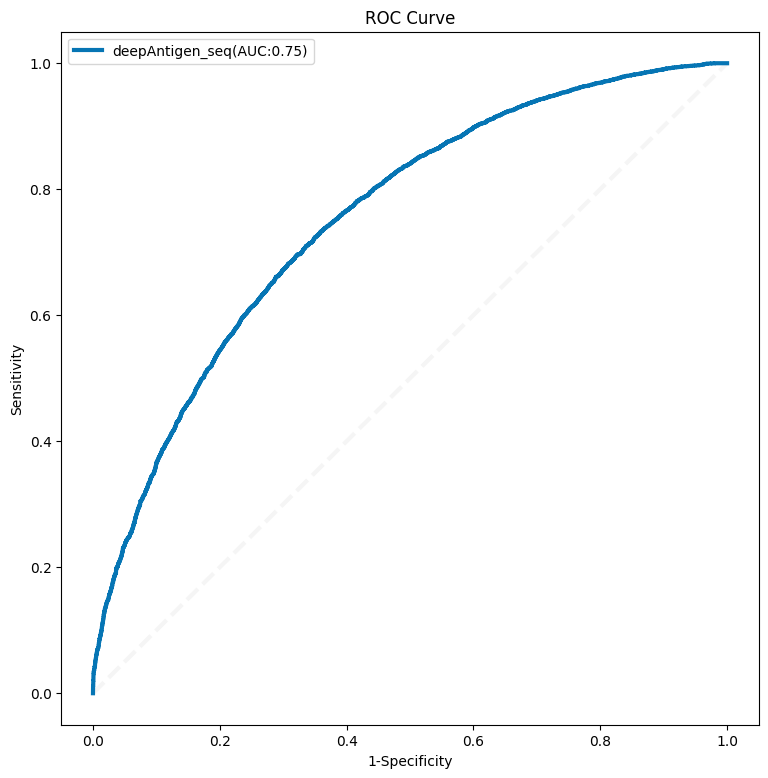

In [5]:
#Draw ROC curve
score_list=list(df['score'])
label_list=list(df['label'])
hhList=[]
LegendLabels=[]
plt.figure(figsize=(9,9))
#font = {'weight' : 'normal',
#'size'   : 20}
#mpl.rc('font', **font)
fpr, tpr, thersholds = roc_curve(label_list, score_list, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot([0,1],[0,1],ls='dashed',lw=3, color='whitesmoke')
hh, = plt.plot(fpr, tpr, color='#0675B4', lw=3)
hhList.append(hh)
LegendLabels.append('deepAntigen_seq'+'(AUC:'+str(round(roc_auc,2))+')')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
legend=plt.legend(hhList,LegendLabels)
plt.show()

## Train deepAntigen using sequence-level anitgen-HLAII binding data

Split the dataset for 10-fold cross-validation

In [6]:
split_data('./test_antigenHLAII/Data/sequence/train.csv',10)

Splited datasets have been saved to./test_antigenHLAII/Data/sequence/k_fold_dataset/


You can alter hyperparameters in 'config_seq.ini', and then start training.

In [7]:
run_antigenHLAII_seq.Train('./test_antigenHLAII/Data/sequence/k_fold_dataset/', config_path='./test_antigenHLAII/config_seq.ini')

Epoch:1 Train_loss:5.0439 ACC:0.6377 AUROC:0.6921 Precision:0.6156 Recall:0.7329 F1:0.6692 AUPR:0.6555
Epoch:2 Train_loss:4.8022 ACC:0.6774 AUROC:0.7370 Precision:0.6442 Recall:0.7927 F1:0.7108 AUPR:0.6956
Epoch:3 Train_loss:4.7291 ACC:0.6876 AUROC:0.7503 Precision:0.6551 Recall:0.7924 F1:0.7172 AUPR:0.7102
Epoch:4 Train_loss:4.6657 ACC:0.6960 AUROC:0.7607 Precision:0.6635 Recall:0.7954 F1:0.7235 AUPR:0.7217
Epoch:5 Train_loss:4.6192 ACC:0.7025 AUROC:0.7684 Precision:0.6704 Recall:0.7965 F1:0.7281 AUPR:0.7319
Epoch:5 Val_loss:4.5034 ACC:0.7185 AUROC:0.7863 Precision:0.6762 Recall:0.8380 F1:0.7484 AUPR:0.7529
==> Saving model...
Epoch:6 Train_loss:4.5996 ACC:0.7040 AUROC:0.7713 Precision:0.6715 Recall:0.7988 F1:0.7296 AUPR:0.7353
Epoch:7 Train_loss:4.5730 ACC:0.7077 AUROC:0.7757 Precision:0.6759 Recall:0.7982 F1:0.7320 AUPR:0.7406
Epoch:8 Train_loss:4.5489 ACC:0.7114 AUROC:0.7794 Precision:0.6798 Recall:0.7994 F1:0.7348 AUPR:0.7450
Epoch:9 Train_loss:4.5361 ACC:0.7129 AUROC:0.7808 Preci

This is a example, we only train 50 epochs to save time. To test the model you just trained, you need to prepare a test dataset 'test.csv' and model parameters 'seq-level_parameters'

In [8]:
df = run_antigenHLAII_seq.Inference('./test_antigenHLAII/Data/sequence/test.csv', model_path='./antigenHLAII_training_log/seq-level_parameters.pt')

peptide:WYQXKPGQPPKLLIYKASTLE
Prediction results have been saved to./antigenHLAII_Output/seq-level/pHLAII_predictions.csv


In [9]:
df

,peptide,alpha_n,beta_n,score,label
0,QAGKEAEKLGQG,DPA1*01:03,DPB1*01:01,0.374021,1
1,TRVGINIFTRLR,DPA1*01:03,DPB1*01:01,0.649740,1
2,QVKRNAVPITPT,DPA1*01:03,DPB1*01:01,0.695249,1
3,ITAVTATSNEIK,DPA1*01:03,DPB1*01:01,0.490852,1
4,PAGKLKYFDKLN,DPA1*01:03,DPB1*01:01,0.467178,1
...,...,...,...,...,...
12688,PRNDRNVFSRLTSNQ,DRA*01:01,DRB5*01:01,0.195245,0
12689,DIPRVTALNRALVTV,DRA*01:01,DRB5*01:01,0.443333,0
12690,TTVGMNGKDKDIPSFT,DRA*01:01,DRB5*01:01,0.578869,0
12691,PVIYAGATSKNKMVSSAFTTE,DRA*01:01,DRB5*01:01,0.286877,0


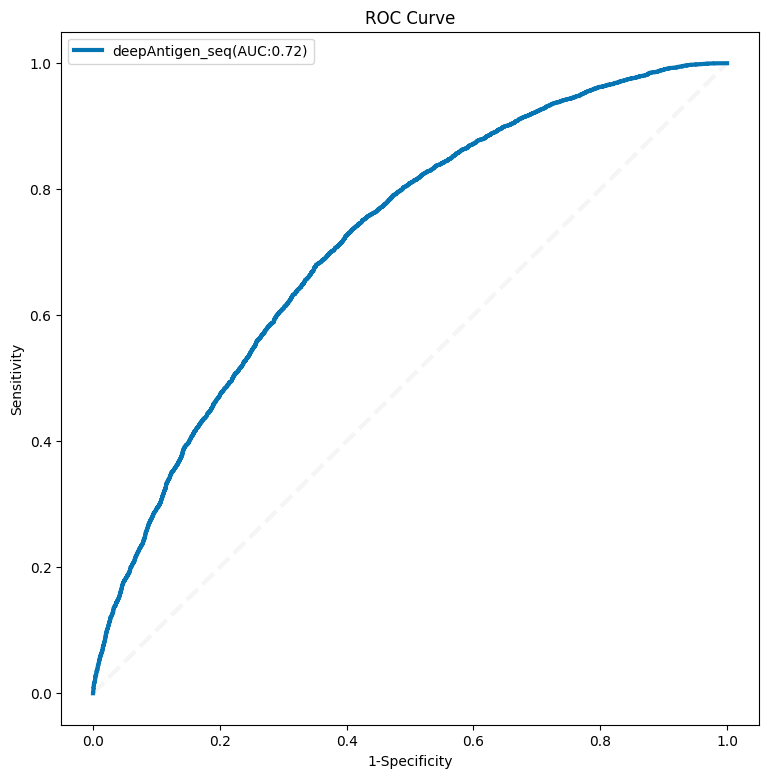

In [10]:
#Draw ROC curve
score_list=list(df['score'])
label_list=list(df['label'])
hhList=[]
LegendLabels=[]
plt.figure(figsize=(9,9))
#font = {'weight' : 'normal',
#'size'   : 20}
#mpl.rc('font', **font)
fpr, tpr, thersholds = roc_curve(label_list, score_list, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot([0,1],[0,1],ls='dashed',lw=3, color='whitesmoke')
hh, = plt.plot(fpr, tpr, color='#0675B4', lw=3)
hhList.append(hh)
LegendLabels.append('deepAntigen_seq'+'(AUC:'+str(round(roc_auc,2))+')')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
legend=plt.legend(hhList,LegendLabels)
plt.show()

## Inference anitgen-HLAII binding at the atom level using deepAntigen

By utilizing parameters provided by us, you can directly predict atom-level contact between antigen and HLAII, requiring only the preparation of the test dataset 'sample.csv'. Although inferring atom-level contact, deepAntigen only requires the residue sequences of antigen and HLAII as inputs.

Prediction results have been saved to./antigenHLAII_Output/atom-level/


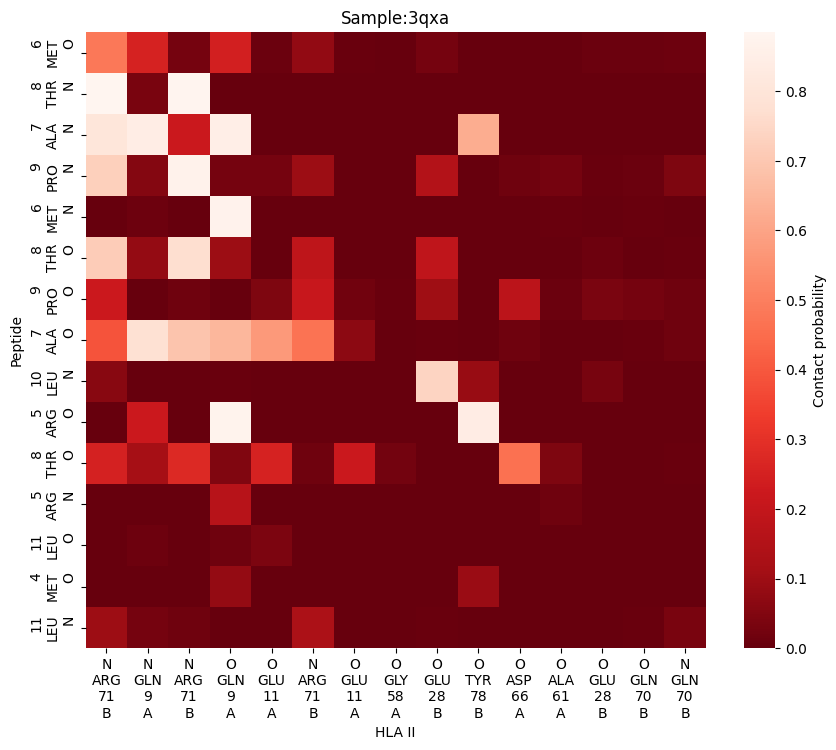

In [11]:
peptide_atoms, HLAII_atoms, contact_maps = run_antigenHLAII_atom.Inference('./test_antigenHLAII/Data/crystal_structure/sample.csv')

The x-axis and y-axis respectively display top-15 crucial atoms of HLA and peptide. The heatmap represents the contact probabilities between these atoms.

## Fine-tune deepAntigen using antigen-HLAII crystal structure data

Preprocess .pdb file in the directory 'pdb' download from Protein Data Bank according meta infomation provided in 'info_noredudant.csv'. 

In [12]:
process_pdb_absolute('./test_antigenHLAII/Data/crystal_structure/pdb', './test_antigenHLAII/Data/crystal_structure/info_noredudant.csv')

1a6a
1aqd
1bx2
1dlh
1fv1
1h15
1hqr
1j8h
1jk8
1klg
1klu
1s9v
1sje
1sjh
1t5w
1uvq
1zgl
2ipk
2nna
2q6w
2seb
3c5j
3l6f
3pdo
3pgc
3qxa
4h1l
4is6
4mcy
4mcz
4md4
4md5
4mdi
4mdj
4ov5
4ozf
4ozh
4ozi
4x5w
4y19
4y1a
4z7u
5jlz
5ks9
5ksu
5ksv
5lax
5ni9
5nig
6atf
6ati
6atz
6bij
6bil
6bin
6bir
6biv
6bix
6biy
6biz
6cpl
6cpn
6cpo
6cqj
6hby
6nix
6px6
6xp6
7kei
7n19
7sg0
7sg1
7sg2
Processed pdb files have been saved to/quejinhao/deepAntigen/test_antigenHLAII/Data/crystal_structure/pdb_Extracted_absolute


Because residue IDs of alpha and beta chains in HLAII are repeative, we renumber residues to distinguish them by the following step.

In [13]:
process_pdb_relative('./test_antigenHLAII/Data/crystal_structure/pdb', './test_antigenHLAII/Data/crystal_structure/info_noredudant.csv')

1a6a
1aqd
1bx2
1dlh
1fv1
1h15
1hqr
1j8h
1jk8
1klg
1klu
1s9v
1sje
1sjh
1t5w
1uvq
1zgl
2ipk
2nna
2q6w
2seb
3c5j
3l6f
3pdo
3pgc
3qxa
4h1l
4is6
4mcy
4mcz
4md4
4md5
4mdi
4mdj
4ov5
4ozf
4ozh
4ozi
4x5w
4y19
4y1a
4z7u
5jlz
5ks9
5ksu
5ksv
5lax
5ni9
5nig
6atf
6ati
6atz
6bij
6bil
6bin
6bir
6biv
6bix
6biy
6biz
6cpl
6cpn
6cpo
6cqj
6hby
6nix
6px6
6xp6
7kei
7n19
7sg0
7sg1
7sg2
Processed pdb files have been saved to/quejinhao/deepAntigen/test_antigenHLAII/Data/crystal_structure/pdb_Extracted_relative


Calculate pairwise distance between atoms on antigen and HLAII for each crystal structure.

In [14]:
calculate_distance('./test_antigenHLAII/Data/crystal_structure/pdb_Extracted_relative/')

6biv
6cpl
5jlz
4x5w
6bir
5nig
6bij
4h1l
6atz
6biy
6atf
1fv1
2seb
6bix
6bin
5ksu
4mcy
7n19
5ni9
4y1a
4ozi
1dlh
2ipk
3l6f
4md5
6bil
4mdj
4y19
6cpo
5ks9
6cqj
1jk8
2q6w
7sg2
6biz
5ksv
2nna
1hqr
7kei
7sg0
6nix
1aqd
1uvq
6hby
4mcz
1sje
1a6a
4mdi
1bx2
1t5w
3pgc
6px6
1s9v
1j8h
1klg
1h15
4ov5
6xp6
1klu
3qxa
1zgl
4is6
7sg1
6ati
5lax
3pdo
1sjh
4z7u
4md4
6cpn
3c5j
4ozf
4ozh
Distance matrixs have been saved to /quejinhao/deepAntigen/test_antigenHLAII/Data/crystal_structure/distance_matrix


Then, you can utilize structural information to fine-tune model that you have pre-trained using sequence-level binding data. You can alter hyperparameters in 'config_atom.ini', and then start fine-tuning.

6atf
Start finetuning topk layer
Epoch:0,Loss:0.5568273266156515
Epoch:1,Loss:0.4925791927509838
Epoch:2,Loss:0.4791778897245725
Epoch:3,Loss:0.46348467220862705
Epoch:4,Loss:0.45802726017104256
Epoch:5,Loss:0.4553207465344005
Epoch:6,Loss:0.45143279598818886
Epoch:7,Loss:0.44172311657004887
Epoch:8,Loss:0.43982134842210346
Epoch:9,Loss:0.43906226174698937
Epoch:10,Loss:0.4381541742218865
Epoch:11,Loss:0.433044261402554
Epoch:12,Loss:0.42903078513012993
Epoch:13,Loss:0.4291529878973961
Epoch:14,Loss:0.42888811147875255
Epoch:15,Loss:0.429010137087769
Epoch:16,Loss:0.42430417819155586
Epoch:17,Loss:0.42585476570659214
Epoch:18,Loss:0.4254167866375711
Epoch:19,Loss:0.42115825083520675
Epoch:20,Loss:0.4202180521355735
Epoch:21,Loss:0.41875167604949737
Epoch:22,Loss:0.4190267473459244
Epoch:23,Loss:0.41944577544927597
Epoch:24,Loss:0.4189180831114451
Epoch:25,Loss:0.41634395884142983
Epoch:26,Loss:0.4167359529270066
Epoch:27,Loss:0.41542857471439576
Epoch:28,Loss:0.416060183611181
Epoch:29

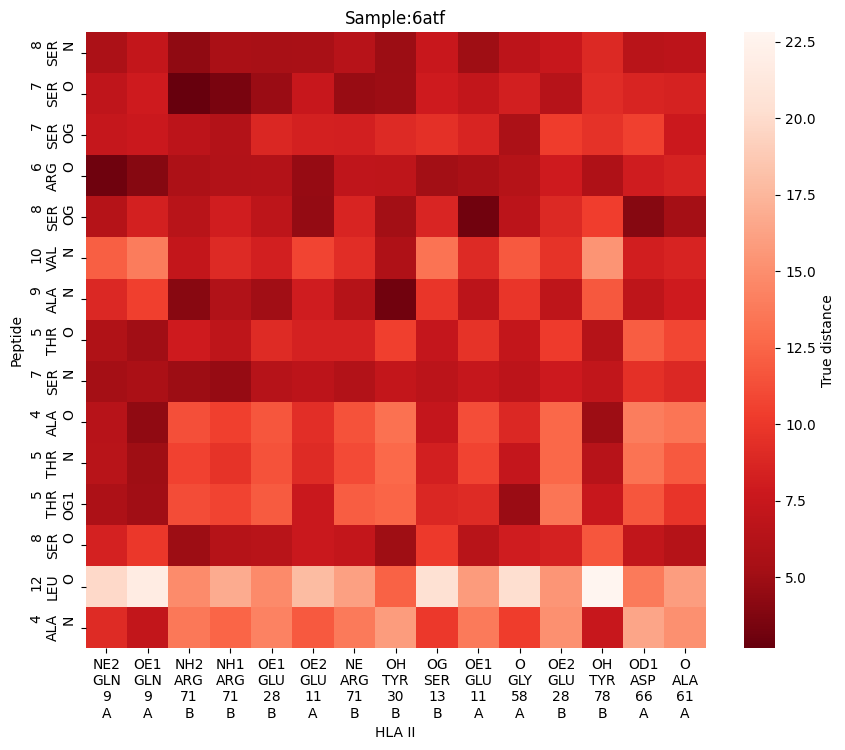

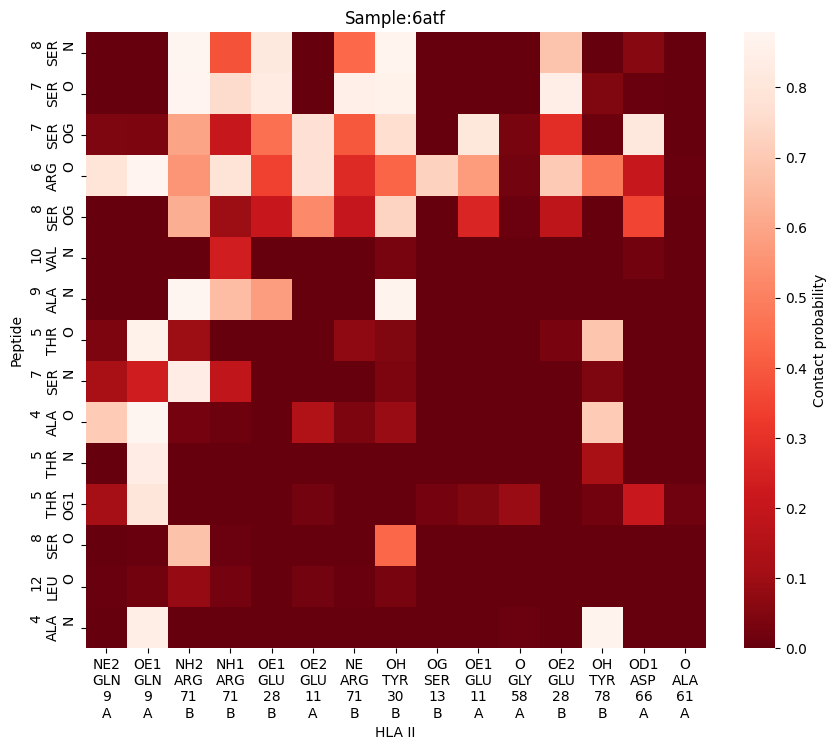

In [15]:
run_antigenHLAII_atom.Train('./test_antigenHLAII/Data/crystal_structure/info_noredudant.csv', config_path='./test_antigenHLAII/config_atom.ini')

Two heatmaps are respectively true distances and contact probabilities between atoms on antigen and HLAII. We only exhibit the results of leaving 6atf for validation, while the remaining crystal structures were used for training